# L1 and L2 Regularization: A quick recap

A lot of the content in this notebook was adapted from others. The following equations and explanation of the probabilistic view of norms are from [this great blog post by Brian Keng](https://bjlkeng.github.io/posts/probabilistic-interpretation-of-regularization/). Some other references:


*   [Visualizing regularization and the L1 and L2 norms](https://towardsdatascience.com/visualizing-regularization-and-the-l1-and-l2-norms-d962aa769932)
*   [This simulation](https://developers.google.com/machine-learning/crash-course/regularization-for-sparsity/l1-regularization) is a really cool demo of weight change during training
*   [A neat simulation](https://explained.ai/regularization/L1vsL2.html) showing coefficients for simulated random loss functions with both norms

<br/>

---

<br/>

Recall that in ordinary least squares (OLS) regression, the maximum likelihood estimate is given by 

\begin{align*}
{\bf \hat{\beta}_{\text{MLE}}}
&= \arg\min_{\bf \beta} \sum_{i=1}^{n} (y_i- (\beta_0 + \beta_1 x_{i,1} + ... + \beta_p x_{i,p}))^2 \\
&= \arg\min_{\bf \beta} \sum_{i=1}^{n} (y_i-\hat{y_i})^2
\end{align*}

**L2 regularization**:
\begin{equation*}
{\bf \hat{\beta}_{\text{L2}}}
= \arg\min_{\bf \beta} \big( \sum_{i=1}^{n} (y_i-(\beta_0 + \beta_1 x_{i,1} + ... + \beta_p x_{i,p}))^2
  + \lambda \sum_{j=0}^{p} | \beta_j | ^2 \big)
\end{equation*}

**L1 regularization**:
\begin{align*}
{\bf \hat{\beta}_{\text{L1}}}
= \arg\min_{\bf \beta} \big( \sum_{i=1}^{n} (y_i- (\beta_0 + \beta_1 x_{i, 1} + ... + \beta_p x_{i,p}))^2
  + \lambda \sum_{j=0}^{p} | \beta_j | \big)
\\
\end{align*}

The question is, what effect do these regularization methods have on the model? More specifically, what happens to the weights when we apply the L1 penalty,  $\lambda \sum | \beta | $, versus the L2 penalty, $\lambda \sum | \beta ^2| $. If we want to use these models for prediction, what impact does the regularization have on the model performance? Finally, does L1 actually introduce sparsity?

Sparsity offers improved robustness and prevents overfitting. The common diagram from topology shows us the minimum point norm for various $\ell_p$ solutions, where p = 0,1,2,3,4,$\infty$. 

<p align="center">
  <img width="550" src="https://drive.google.com/uc?export=view&id=1peLyPKBUT8ufmph9mgQNZ7vIZasF21vV">
</p>

Technically, L0 is not a norm, but it  *would* be the one that maximizes sparsity. However, we can't find the minimum L0 solution using convex optimization. This is what leads to the use of L1 norm for maximizing sparse solutions since it is computable using convex optimization. This *tends* to maximizes sparsity except in the case that the solutio lies along the diamond. The following figure is from the classic *Elements of Statistical Learning* and shows how the L1 norm introduces sparsity compared to L2. 

<p align="center">
  <img width="550" src="https://i.stack.imgur.com/oVJDB.png">
</p>

We will return to this image later, but for now, we can see that the contours intersect with a sparse solution for the L1 solution but not for L2. The first thing I want to do is look at two datasets and see what effect L1 and L2 have on our estimates of the model parameters. 


# Setup: Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import matplotlib
import seaborn as sns

from sklearn.datasets import load_boston, load_diabetes, make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, lasso_path, enet_path
from sklearn.metrics import mean_squared_error, r2_score

#Dataset: Boston Housing

In [ ]:
#@title Load data
boston = load_boston()
X=boston.data
y=boston.target
#print(boston.feature_names)
boston_df = pd.DataFrame(boston.data,columns=boston.feature_names)
boston_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## Fit regression models: OLS, Ridge (L2), and Lasso (L1)

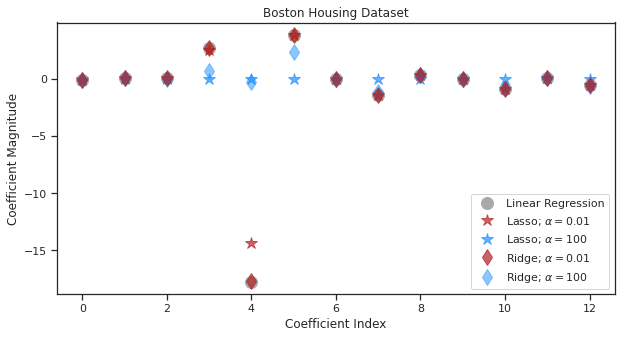

In [ ]:
#@title Lets look at the magnitude of the coefficients for each method
# This section was adapted from https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b

# Fit linear regression model
lr = LinearRegression()
lr.fit(X,y)

# Fit ridge regression w/low and high alpha vals
rr001 = Ridge(alpha=0.01) 
rr001.fit(X,y)

rr100 = Ridge(alpha=100)
rr100.fit(X, y)

# Fit lasso w/ low and high alpha values
la001 = Lasso(alpha=0.01) 
la001.fit(X,y)

la100 = Lasso(alpha=100)
la100.fit(X, y)

markersize=12
# Plot results of parameter magnitude
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,5))
plt.plot(lr.coef_,alpha=1,linestyle='none',marker='o',markersize=markersize,color='darkgray',label='Linear Regression')
plt.plot(la001.coef_,alpha=0.7,linestyle='none',marker='*',markersize=markersize,color='firebrick',label=r'Lasso; $\alpha = 0.01$') 
plt.plot(la100.coef_,alpha=0.7,linestyle='none',marker='*',markersize=markersize,color='dodgerblue',label=r'Lasso; $\alpha = 100$') 
plt.plot(rr001.coef_,alpha=0.7,linestyle='none',marker='d',markersize=markersize,color='firebrick',label=r'Ridge; $\alpha = 0.01$',zorder=7) 
plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=markersize,color='dodgerblue',label=r'Ridge; $\alpha = 100$') 

plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend(loc=4)
plt.title('Boston Housing Dataset')
plt.show()


Text(0.5, 1.0, 'L1')

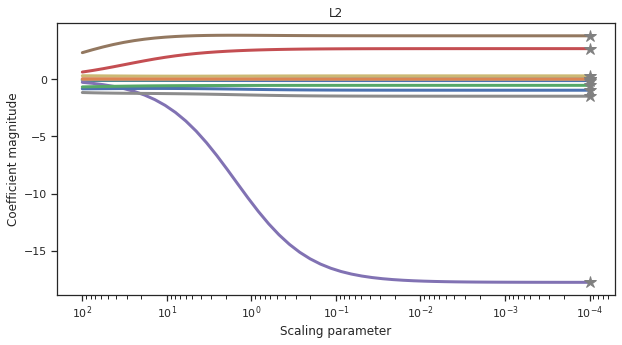

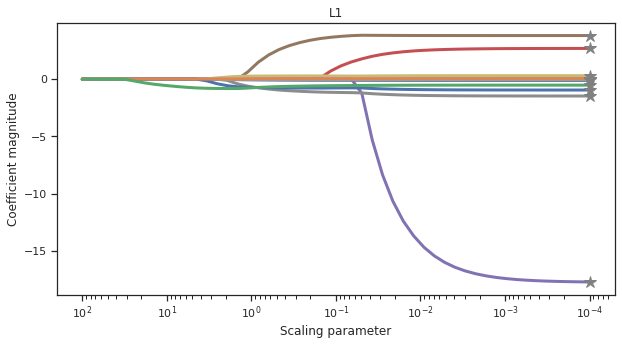

In [ ]:
#@title What happens to the coefficients as we change the scaling parameter?
# Generate list of scaling parameters
alphas = np.logspace(start=-4,stop=2,num=50)

coefs_lr = []
coefs_rr = []
coefs_ll = []
for this_alpha in alphas:

  # Fit linear regression model
  lr = LinearRegression()
  lr.fit(X,y)  
  coefs_lr = lr.coef_

  # Fit ridge regression
  rr = Ridge(alpha=this_alpha) 
  rr.fit(X,y)
  coefs_rr.append(rr.coef_)

  # Fit lasso
  ll = Lasso(alpha=this_alpha) 
  ll.fit(X,y)
  coefs_ll.append(ll.coef_)

# Plot ridge regression
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.plot(alphas,coefs_rr,linewidth=3)
ax.plot(alphas[0]*np.ones_like(coefs_lr),coefs_lr,linestyle='none',marker='*',markersize=markersize,color='grey')
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('Scaling parameter')
plt.ylabel('Coefficient magnitude')
plt.axis('tight')
plt.title('L2')

# Plot lasso
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.plot(alphas,coefs_ll,linewidth=3)
ax.plot(alphas[0]*np.ones_like(coefs_lr),coefs_lr,linestyle='none',marker='*',markersize=markersize,color='grey')
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('Scaling parameter')
plt.ylabel('Coefficient magnitude')
plt.axis('tight')
plt.title('L1')


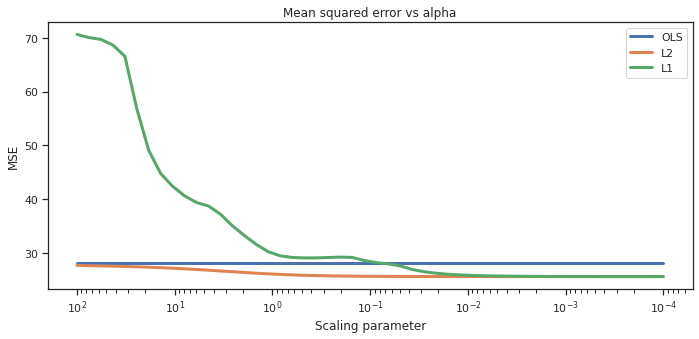

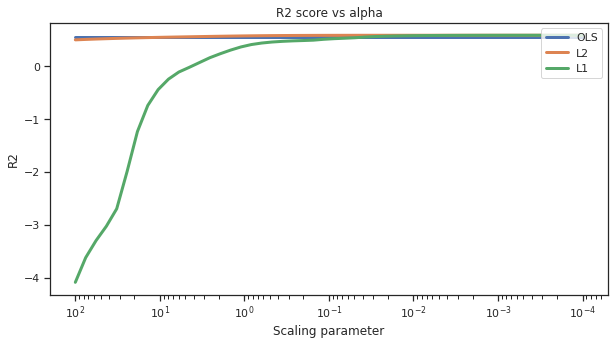

In [ ]:
#@title How does the prediction performance change?

# Generate list of scaling parameters
alphas = np.logspace(start=-4,stop=2,num=50)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

mse_lr = []
mse_rr = []
mse_ll = []
r2_lr = []
r2_rr = []
r2_ll = []
for this_alpha in alphas:

  # Fit linear regression model
  lr = LinearRegression()
  lr.fit(X_train,y_train)  
  y_lr = lr.predict(X_test)
  mse_lr.append(mean_squared_error(y_lr,y_test))
  r2_lr.append(r2_score(y_lr,y_test))

  # Fit ridge regression
  rr = Ridge(alpha=this_alpha) 
  rr.fit(X,y)
  y_rr = rr.predict(X_test)
  mse_rr.append(mean_squared_error(y_rr,y_test))
  r2_rr.append(r2_score(y_rr,y_test))

  # Fit lasso
  ll = Lasso(alpha=this_alpha) 
  ll.fit(X,y)
  y_ll = ll.predict(X_test)
  mse_ll.append(mean_squared_error(y_ll,y_test))
  r2_ll.append(r2_score(y_ll,y_test))

# Plot MSE
plt.figure(figsize=(10,5),tight_layout=True)
ax = plt.gca()
ax.plot(alphas,mse_lr,linewidth=3,label='OLS')
ax.plot(alphas,mse_rr,linewidth=3,label='L2')
ax.plot(alphas,mse_ll,linewidth=3,label='L1')

ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('Scaling parameter')
plt.ylabel('MSE')
plt.axis('tight')
plt.title('Mean squared error vs alpha')
plt.legend(loc=1)
plt.show()

# Plot R2
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.plot(alphas,r2_lr,linewidth=3,label='OLS')
ax.plot(alphas,r2_rr,linewidth=3,label='L2')
ax.plot(alphas,r2_ll,linewidth=3,label='L1')

ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('Scaling parameter')
plt.ylabel('R2')
plt.axis('tight')
plt.title('R2 score vs alpha')
plt.legend(loc=1)
plt.show()

#Dataset: Diabetes

In [ ]:
#@title Let's try the whole thing again with a different dataset (sklearn.datasets.load_diabetes).
# Load data
diabetes = load_diabetes()
X=diabetes.data
y=diabetes.target
diabetes_df = pd.DataFrame(diabetes.data,columns=diabetes.feature_names)
diabetes_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


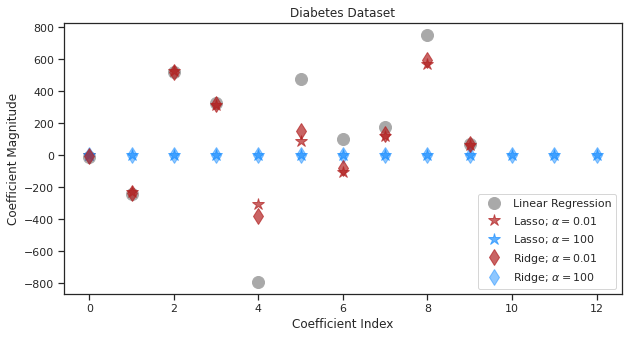

In [ ]:
#@title Fit ridge and lasso models

# Fit linear regression model
lr = LinearRegression()
lr.fit(X,y)

# Fit ridge regression w/low and high alpha vals
rr001 = Ridge(alpha=0.01) 
rr001.fit(X,y)

rr100 = Ridge(alpha=100)
rr100.fit(X_train, y_train)

# Fit lasso w/ low and high alpha values
la001 = Lasso(alpha=0.01) 
la001.fit(X,y)

la100 = Lasso(alpha=100)
la100.fit(X_train, y_train)

# Plot results of parameter magnitude
#matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,5))
plt.plot(lr.coef_,alpha=1,linestyle='none',marker='o',markersize=markersize,color='darkgray',label='Linear Regression')
plt.plot(la001.coef_,alpha=0.7,linestyle='none',marker='*',markersize=markersize,color='firebrick',label=r'Lasso; $\alpha = 0.01$') 
plt.plot(la100.coef_,alpha=0.7,linestyle='none',marker='*',markersize=markersize,color='dodgerblue',label=r'Lasso; $\alpha = 100$') 
plt.plot(rr001.coef_,alpha=0.7,linestyle='none',marker='d',markersize=markersize,color='firebrick',label=r'Ridge; $\alpha = 0.01$',zorder=7) 
plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=markersize,color='dodgerblue',label=r'Ridge; $\alpha = 100$') 

plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend(loc=4)
plt.title('Diabetes Dataset')
plt.show()

Text(0.5, 1.0, 'L1')

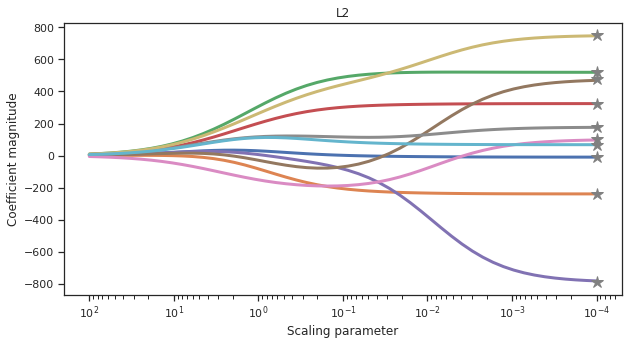

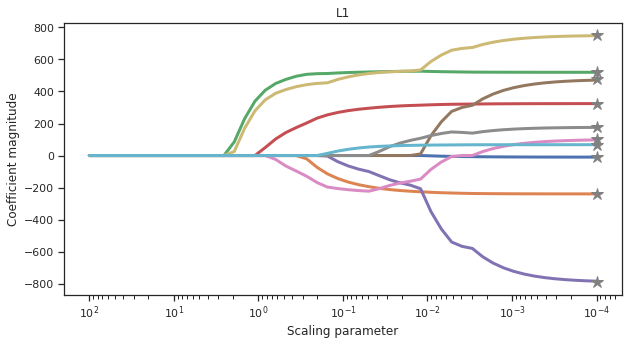

In [ ]:
#@title What happens to the coefficients as we change the scaling parameter?
# Generate list of scaling parameters
alphas = np.logspace(start=-4,stop=2,num=50)

coefs_lr = []
coefs_rr = []
coefs_ll = []
for this_alpha in alphas:

  # Fit linear regression model
  lr = LinearRegression()
  lr.fit(X,y)  
  coefs_lr = lr.coef_

  # Fit ridge regression
  rr = Ridge(alpha=this_alpha) 
  rr.fit(X,y)
  coefs_rr.append(rr.coef_)

  # Fit lasso
  ll = Lasso(alpha=this_alpha) 
  ll.fit(X,y)
  coefs_ll.append(ll.coef_)

# Plot coefficients of ridge regression (L2 norm)
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.plot(alphas,coefs_rr,linewidth=3)
ax.plot(alphas[0]*np.ones_like(coefs_lr),coefs_lr,linestyle='none',marker='*',markersize=markersize,color='grey')
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('Scaling parameter')
plt.ylabel('Coefficient magnitude')
plt.axis('tight')
plt.title('L2')

# Plot coefficients of Lasso (L1 norm)
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.plot(alphas,coefs_ll,linewidth=3)
ax.plot(alphas[0]*np.ones_like(coefs_lr),coefs_lr,linestyle='none',marker='*',markersize=markersize,color='grey')
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('Scaling parameter')
plt.ylabel('Coefficient magnitude')
plt.axis('tight')
plt.title('L1')

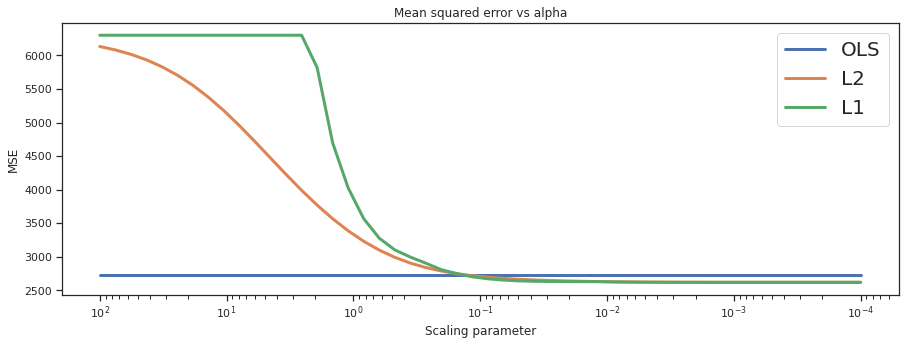

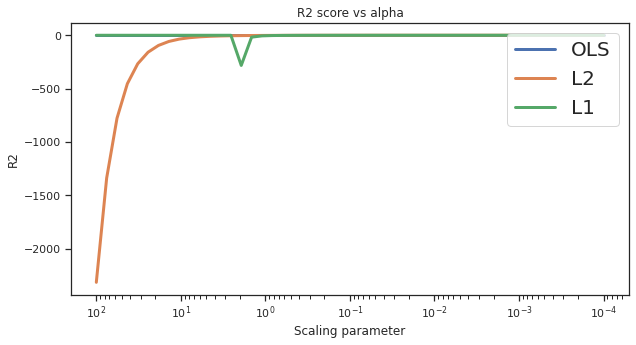

In [ ]:
#@title How does the prediction performance change?

# Generate list of scaling parameters
alphas = np.logspace(start=-4,stop=2,num=50)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

mse_lr = []
mse_rr = []
mse_ll = []
r2_lr = []
r2_rr = []
r2_ll = []
for this_alpha in alphas:

  # Fit linear regression model
  lr = LinearRegression()
  lr.fit(X_train,y_train)  
  y_lr = lr.predict(X_test)
  mse_lr.append(mean_squared_error(y_lr,y_test))
  r2_lr.append(r2_score(y_lr,y_test))

  # Fit ridge regression
  rr = Ridge(alpha=this_alpha) 
  rr.fit(X,y)
  y_rr = rr.predict(X_test)
  mse_rr.append(mean_squared_error(y_rr,y_test))
  r2_rr.append(r2_score(y_rr,y_test))

  # Fit lasso
  ll = Lasso(alpha=this_alpha) 
  ll.fit(X,y)
  y_ll = ll.predict(X_test)
  mse_ll.append(mean_squared_error(y_ll,y_test))
  r2_ll.append(r2_score(y_ll,y_test))


# Plot MSE
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.plot(alphas,mse_lr,linewidth=3,label='OLS')
ax.plot(alphas,mse_rr,linewidth=3,label='L2')
ax.plot(alphas,mse_ll,linewidth=3,label='L1')

ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('Scaling parameter')
plt.ylabel('MSE')
plt.axis('tight')
plt.title('Mean squared error vs alpha')
plt.legend(fontsize=20,loc=1)
plt.show()

# Plot R2
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.plot(alphas,r2_lr,linewidth=3,label='OLS')
ax.plot(alphas,r2_rr,linewidth=3,label='L2')
ax.plot(alphas,r2_ll,linewidth=3,label='L1')

ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('Scaling parameter')
plt.ylabel('R2')
plt.axis('tight')
plt.title('R2 score vs alpha')
plt.legend(fontsize=20,loc=1)
plt.show()

# What is the intuition behind the effect of L1 and L2 on the model?

Clearly the scaling parameter has a huge effect on the model weights. The important thing to remember is that optimizing the parameters means minimizing the loss function. In the case of Lasso or Ridge regression, that means minimizing the sum of square errors and the regularization term. 

**L2 regularization**:
\begin{equation*}
{\bf \hat{\beta}_{\text{L2}}}
= \arg\min_{\bf \beta} \big( \sum_{i=1}^{n} (y_i-(\beta_0 + \beta_1 x_{i,1} + ... + \beta_p x_{i,p}))^2
  + \lambda \sum_{j=0}^{p} | \beta_j | ^2 \big)
\end{equation*}

**L1 regularization**:
\begin{align*}
{\bf \hat{\beta}_{\text{L1}}}
= \arg\min_{\bf \beta} \big( \sum_{i=1}^{n} (y_i- (\beta_0 + \beta_1 x_{i, 1} + ... + \beta_p x_{i,p}))^2
  + \lambda \sum_{j=0}^{p} | \beta_j | \big)
\\
\end{align*}

When we compute the gradient of the loss, we are intrinsically computing the gradient of the regularization term within the loss. Notice in the figure below (from [here](https://towardsdatascience.com/visualizing-regularization-and-the-l1-and-l2-norms-d962aa769932)), that the derivative of the L2 norm is linear while the derivative of L1 is constant. This means that the L2 norm has the effect of shrinking large weights quickly since the slope decreases as it approaches zero; however, the weights will likely never actually reach zero since the updates will get smaller and smaller. On the other hand, the L1 norm has a constant derivative, meaning the update does not change with decreasing *w*. L1 will drive many parameters to zero, thus introducing sparsity into the model. 

<br/>

<img src="https://miro.medium.com/max/700/1*etUdoAT3P51qjMiadDRHhQ.gif" >

<br/>

Now, let's return to the earlier image the constraints imposed by  L1 and L2:

<br/>

<p align="center">
    <img height=250 src="https://explained.ai/regularization/images/L1contour.png" hspace=15>
  <img height=250 src="https://explained.ai/regularization/images/L2contour.png">
</p>

These images show how L1 is able to achieve sparsity while L2 cannot. Here is a zoomed in view for an L2 solution that is very close to zero but never actually gets there:


<p align="center">
    <img height=350 src="https://explained.ai/regularization/images/L1L2contour.png">
</p>




[Check out this neat simulation](https://developers.google.com/machine-learning/crash-course/regularization-for-sparsity/l1-regularization) that shows the effect of L1 and L2 on training of network weights.

# A probabilistic view of L1 and L2 regularization 

In some cases, we not only wish to maximize the likelihood but instead maximize the posterior probability of the model parameters given the data. Starting with Bayes theorem:

\begin{align*}
P(\theta | y) &= \frac{P(y | \theta) P(\theta)}{P(y)} \\
\text{posterior} &= \frac{\text{likelihood} \cdot \text{prior}}{\text{evidence}}
\end{align*}

A complete solution would be to solve for the posterior distribution of the parameters, but the common approach is to find the maximum, i.e., the maximum a posteior probability estimate, or MAP. Notice that we can get rid of the *evidence*, $P(y)$, since it does not depend on the parameters. 

\begin{align*}
{\bf \hat{\theta}_{\text{MAP}}} &= \arg\max_{\bf \theta} P(\theta | y) \\
&= \arg\max_{\bf \theta} \frac{P(y | \theta) P(\theta)}{P(y)} \\
&= \arg\max_{\bf \theta} P(y | \theta) P(\theta) \\
&= \arg\max_{\bf \theta} \log(P(y | \theta) P(\theta)) \\
&= \arg\max_{\bf \theta} \log P(y | \theta) + \log P(\theta)
\end{align*}

##Normally distributed parameters

Let us first assume that our parameters are drawn from a normal distribution. We can asign a zero-mean normal prior to each parameter and our likelihood function becomes:

\begin{align*}
 &\arg\max_{\bf \beta} \Big[ \log \prod_{i=1}^{n} \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(y_i- (\beta_0 + \beta_1 x_{i,1} + ... + \beta_p x_{i,p}))^2}{2\sigma^2}}
 + \log \prod_{j=0}^{p} \frac{1}{\tau\sqrt{2\pi}}e^{-\frac{\beta_j^2}{2\tau^2}} \Big] \\
&= \arg\max_{\bf \beta} \Big[- \sum_{i=1}^{n} {\frac{(y_i- (\beta_0 + \beta_1 x_{i,1} + ... + \beta_p x_{i,p}))^2}{2\sigma^2}}
 - \sum_{j=0}^{p} {\frac{\beta_j^2}{2\tau^2}} \Big]\\
&= \arg\min_{\bf \beta} \frac{1}{2\sigma^2} \big[ \sum_{i=1}^{n} (y_i-(\beta_0 + \beta_1 x_{i,1} + ... + \beta_p x_{i,p}))^2
 + \frac{\sigma^2}{\tau^2} \sum_{j=0}^{p} \beta_j^2 \big] \\
&= \arg\min_{\bf \beta} \big[ \sum_{i=1}^{n} (y_i-(\beta_0 + \beta_1 x_{i,1} + ... + \beta_p x_{i,p}))^2 + \lambda \sum_{j=0}^{p} \beta_j^2 \big]
\end{align*}


There are a lot of math tricks and simplification that Brian Keng does in his [blog post on this topic ](https://bjlkeng.github.io/posts/probabilistic-interpretation-of-regularization/), but the main take-away should be clear. Our final result is minimizing the sum of squared errors plus the L2 penalty!

Now, let's go through the entire process again but start with a different prior on our parameters. Here we will choose a spare prior to model the parameter distribution: a zero-mean Laplace distribution. 

\begin{align*}
 &\arg\max_{\bf \beta} \Big[ \log \prod_{i=1}^{n} \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(y_i- (\beta_0 + \beta_1 x_{i,1} + ... + \beta_p x_{i,p}))^2}{2\sigma^2}}
 + \log \prod_{j=0}^{p} \frac{1}{2b}e^{-\frac{|\beta_j|}{2b}} \Big] \\
&= \arg\max_{\bf \beta} \Big[- \sum_{i=1}^{n} {\frac{(y_i- (\beta_0 + \beta_1 x_{i,1} + ... + \beta_p x_{i,p}))^2}{2\sigma^2}}
 - \sum_{j=0}^{p} {\frac{|\beta_j|}{2b}} \Big]\\
&= \arg\min_{\bf \beta} \frac{1}{2\sigma^2} \big[ \sum_{i=1}^{n} (y_i-(\beta_0 + \beta_1 x_{i,1} + ... + \beta_p x_{i,p}))^2
 + \frac{\sigma^2}{b} \sum_{j=0}^{p} |\beta_j| \big] \\
&= \arg\min_{\bf \beta} \big[ \sum_{i=1}^{n} (y_i-(\beta_0 + \beta_1 x_{i,1} + ... + \beta_p x_{i,p}))^2 + \lambda \sum_{j=0}^{p} |\beta_j| \big]
\end{align*}

We can see that this give us the solution for minimizing the least squares estimate plus the L1 norm!


# What happens to the MAP when the weights are drawn from a known distribution?

Thanks to Richard for discussion on this topic. The code in the following section was adapted from some code he shared with me. 

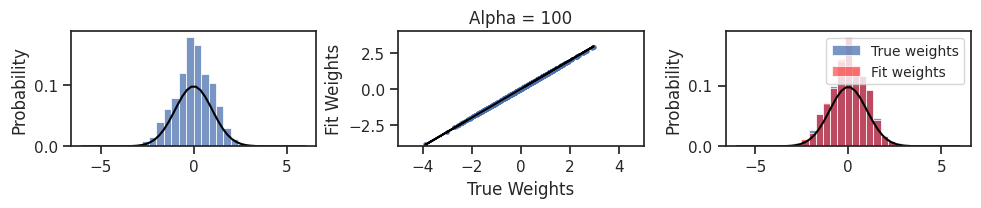

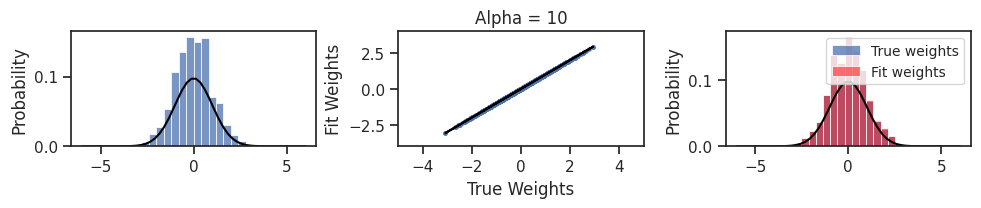

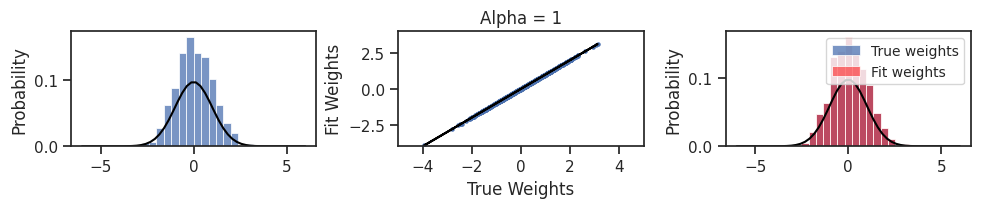

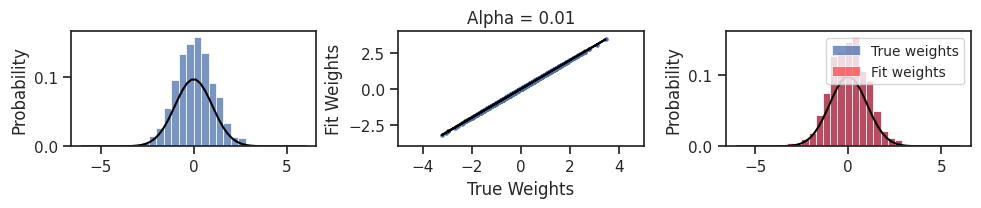

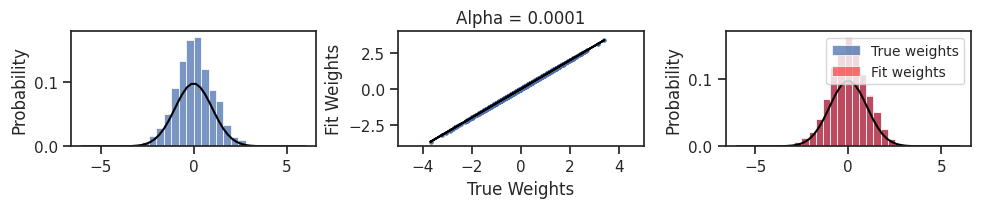

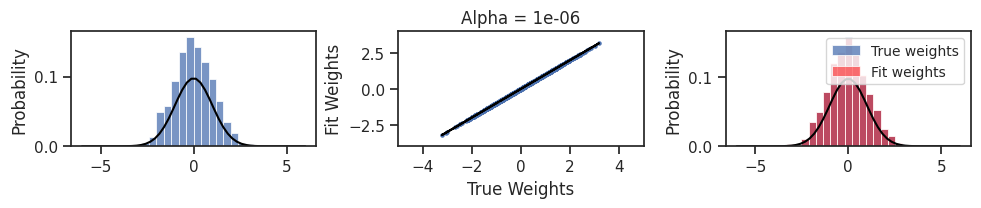

In [ ]:
#@title Draw samples from Gaussian prior and fit weights using Ridge regression (L2 penalty)
for ii,this_alpha in enumerate([100,10,1,.01,.0001,.000001]): #
      n = 10000         # define number of data points
      p = 1000          # define number of regressors
      x = np.random.randn(n,p) # Generate regressors

      # Sample true regression weights from exponential prior
      true_weights = np.random.normal(size=p)

      # Generate data: y = w*x + noise
      noise = 0.1*np.random.randn(n)
      y = x @ true_weights + noise

      w_grid = np.linspace(start=-6,stop=6,num=50)
      mu = 0
      sigma = 1
      p_grid = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (w_grid - mu)**2 / (2 * sigma**2) )

      # Perform ridge regression
      rr = Ridge(alpha=this_alpha,fit_intercept=False)
      rr.fit(x,y)

      # Generate figure
      sns.set_theme(style="ticks")
      fig, axes = plt.subplots(1,3, figsize=(10,1.85), sharey='none', dpi=100)
      fig.tight_layout()

      # First axis
      sns.histplot(true_weights, binrange=[-6,6],ax=axes[0],bins=30,stat='probability')
      axes[0].plot(w_grid,p_grid/sum(p_grid),color='black')

      # Second axis
      axes[1].scatter(true_weights,rr.coef_,s=5)
      axes[1].plot(true_weights,true_weights,color='black')
      axes[1].set_xlim([-5,5])
      axes[1].set_ylim([-4,4])
      axes[1].set_xlabel("True Weights")
      axes[1].set_ylabel("Fit Weights")
      axes[1].set_title("Alpha = " + str(this_alpha))

      # Third axis
      sns.histplot(true_weights, binrange=[-6,6],ax=axes[2],bins=31,stat='probability',label='True weights')
      sns.histplot(rr.coef_, binrange=[-6,6],ax=axes[2],bins=31,stat='probability',color='red',alpha=.5,label='Fit weights')
      axes[2].plot(w_grid,p_grid/sum(p_grid),color='black')
      axes[2].legend(fontsize=10)

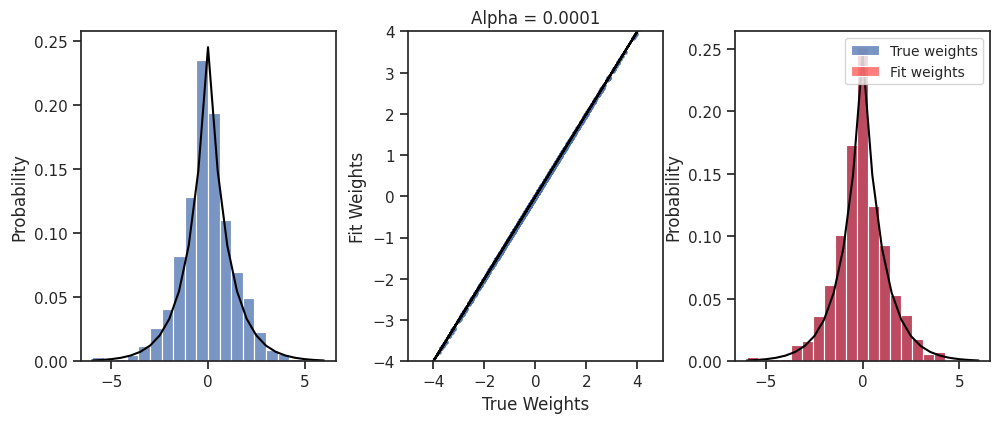

In [ ]:
#@title Let's explore the distribution of the weights for Lasso with alpha=0.0001 --> 0.0001 * sum(abs(weights)) (i.e., a very small penalty on the cost).
for ii,this_alpha in enumerate([.0001]): #[10,1,.01,.0001]
      n = 10000         # define number of data points
      p = 1000          # define number of regressors
      x = np.random.randn(n,p) # Generate regressors

      # Sample true regression weights from exponential prior
      true_weights = np.random.laplace(loc=0.0, scale=1, size=(1000))#np.multiply(np.random.exponential(1,p),np.sign(np.random.rand(p)-0.5))

      # Generate data: y = w*x + noise
      noise = 0.1*np.random.randn(n)
      y = x @ true_weights + noise

      w_grid = np.linspace(start=-6,stop=6,num=25)
      p_grid = np.exp(-np.abs(w_grid))

      # Perform lasso
      ll = Lasso(alpha=this_alpha,fit_intercept=False)
      ll.fit(x,y)

      # Generate figure
      sns.set_theme(style="ticks")
      fig, axes = plt.subplots(1,3, figsize=(10,4), sharey='none', dpi=100)
      fig.tight_layout()

      # First axis
      sns.histplot(true_weights, binrange=[-6,6],ax=axes[0],bins=20,stat='probability')
      axes[0].plot(w_grid,p_grid/sum(p_grid),color='black')

      # Second axis
      axes[1].scatter(true_weights,ll.coef_,s=5)
      axes[1].plot(true_weights,true_weights,color='black')
      axes[1].set_xlim([-5,5])
      axes[1].set_ylim([-4,4])
      axes[1].set_xlabel("True Weights")
      axes[1].set_ylabel("Fit Weights")
      axes[1].set_title("Alpha = " + str(this_alpha))

      # Third axis
      sns.histplot(true_weights, binrange=[-6,6],ax=axes[2],bins=21,stat='probability',label='True weights')
      sns.histplot(ll.coef_, binrange=[-6,6],ax=axes[2],bins=21,stat='probability',color='red',alpha=.5,label='Fit weights')
      axes[2].plot(w_grid,p_grid/sum(p_grid),color='black')
      axes[2].legend(fontsize=10)

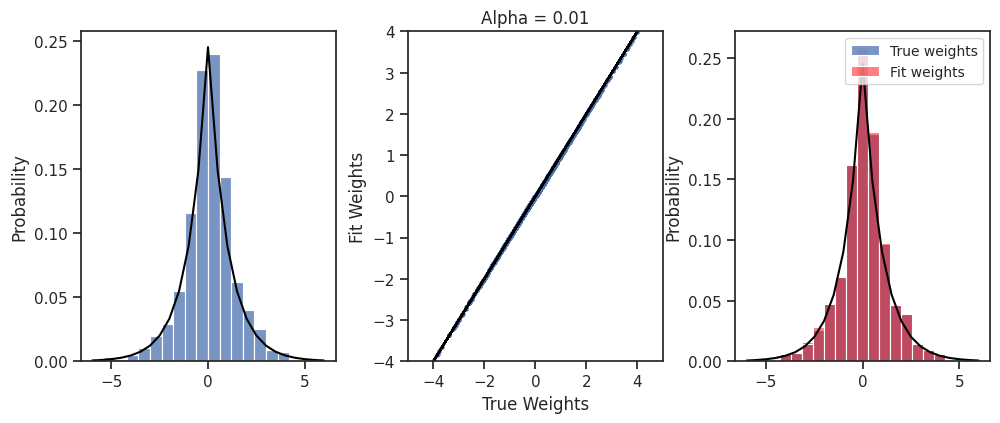

In [ ]:
#@title Alpha=0.01 --> 0.01*sum(abs(weights)) (i.e., a small penalty on the cost).
for ii,this_alpha in enumerate([.01]): #[10,1,.01,.0001]
      n = 10000         # define number of data points
      p = 1000          # define number of regressors
      x = np.random.randn(n,p) # Generate regressors

      # Sample true regression weights from exponential prior
      true_weights = np.random.laplace(loc=0.0, scale=1, size=(1000))#np.multiply(np.random.exponential(1,p),np.sign(np.random.rand(p)-0.5))

      # Generate data: y = w*x + noise
      noise = 0.1*np.random.randn(n)
      y = x @ true_weights + noise

      w_grid = np.linspace(start=-6,stop=6,num=25)
      p_grid = np.exp(-np.abs(w_grid))

      # Perform lasso
      ll = Lasso(alpha=this_alpha,fit_intercept=False)
      ll.fit(x,y)

      # Generate figure
      sns.set_theme(style="ticks")
      fig, axes = plt.subplots(1,3, figsize=(10,4), sharey='none', dpi=100)
      fig.tight_layout()

      # First axis
      sns.histplot(true_weights, binrange=[-6,6],ax=axes[0],bins=20,stat='probability')
      axes[0].plot(w_grid,p_grid/sum(p_grid),color='black')

      # Second axis
      axes[1].scatter(true_weights,ll.coef_,s=5)
      axes[1].plot(true_weights,true_weights,color='black')
      axes[1].set_xlim([-5,5])
      axes[1].set_ylim([-4,4])
      axes[1].set_xlabel("True Weights")
      axes[1].set_ylabel("Fit Weights")
      axes[1].set_title("Alpha = " + str(this_alpha))

      # Third axis
      sns.histplot(true_weights, binrange=[-6,6],ax=axes[2],bins=21,stat='probability',label='True weights')
      sns.histplot(ll.coef_, binrange=[-6,6],ax=axes[2],bins=21,stat='probability',color='red',alpha=.5,label='Fit weights')
      axes[2].plot(w_grid,p_grid/sum(p_grid),color='black')
      axes[2].legend(fontsize=10)

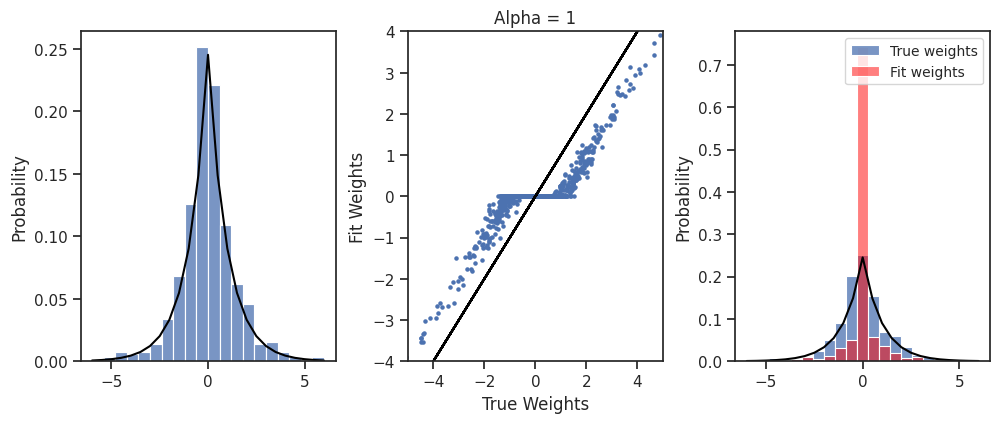

In [ ]:
#@title Alpha=1 --> sum(abs(weights)).
for ii,this_alpha in enumerate([1]): #[10,1,.01,.0001]
      n = 10000         # define number of data points
      p = 1000          # define number of regressors
      x = np.random.randn(n,p) # Generate regressors

      # Sample true regression weights from exponential prior
      true_weights = np.random.laplace(loc=0.0, scale=1, size=(1000))#np.multiply(np.random.exponential(1,p),np.sign(np.random.rand(p)-0.5))

      # Generate data: y = w*x + noise
      noise = 0.1*np.random.randn(n)
      y = x @ true_weights + noise

      w_grid = np.linspace(start=-6,stop=6,num=25)
      p_grid = np.exp(-np.abs(w_grid))

      # Perform lasso
      ll = Lasso(alpha=this_alpha,fit_intercept=False)
      ll.fit(x,y)

      # Generate figure
      sns.set_theme(style="ticks")
      fig, axes = plt.subplots(1,3, figsize=(10,4), sharey='none', dpi=100)
      fig.tight_layout()

      # First axis
      sns.histplot(true_weights, binrange=[-6,6],ax=axes[0],bins=20,stat='probability')
      axes[0].plot(w_grid,p_grid/sum(p_grid),color='black')

      # Second axis
      axes[1].scatter(true_weights,ll.coef_,s=5)
      axes[1].plot(true_weights,true_weights,color='black')
      axes[1].set_xlim([-5,5])
      axes[1].set_ylim([-4,4])
      axes[1].set_xlabel("True Weights")
      axes[1].set_ylabel("Fit Weights")
      axes[1].set_title("Alpha = " + str(this_alpha))

      # Third axis
      sns.histplot(true_weights, binrange=[-6,6],ax=axes[2],bins=21,stat='probability',label='True weights')
      sns.histplot(ll.coef_, binrange=[-6,6],ax=axes[2],bins=21,stat='probability',color='red',alpha=.5,label='Fit weights')
      axes[2].plot(w_grid,p_grid/sum(p_grid),color='black')
      axes[2].legend(fontsize=10)

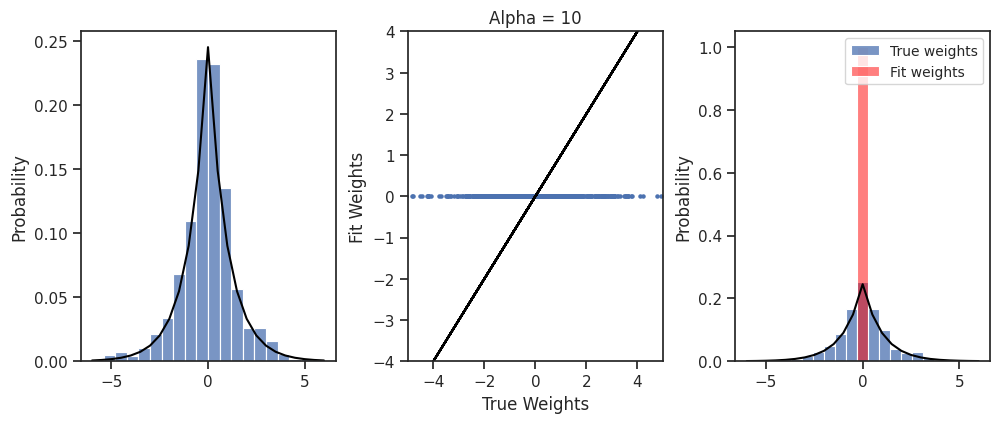

In [ ]:
#@title Alpha=10 --> 10 * sum(abs(weights))
for ii,this_alpha in enumerate([10]): #[10,1,.01,.0001]
      n = 10000         # define number of data points
      p = 1000          # define number of regressors
      x = np.random.randn(n,p) # Generate regressors

      # Sample true regression weights from exponential prior
      true_weights = np.random.laplace(loc=0.0, scale=1, size=(1000))#np.multiply(np.random.exponential(1,p),np.sign(np.random.rand(p)-0.5))

      # Generate data: y = w*x + noise
      noise = 0.1*np.random.randn(n)
      y = x @ true_weights + noise

      w_grid = np.linspace(start=-6,stop=6,num=25)
      p_grid = np.exp(-np.abs(w_grid))

      # Perform lasso
      ll = Lasso(alpha=this_alpha,fit_intercept=False)
      ll.fit(x,y)

      # Generate figure
      sns.set_theme(style="ticks")
      fig, axes = plt.subplots(1,3, figsize=(10,4), sharey='none', dpi=100)
      fig.tight_layout()

      # First axis
      sns.histplot(true_weights, binrange=[-6,6],ax=axes[0],bins=20,stat='probability')
      axes[0].plot(w_grid,p_grid/sum(p_grid),color='black')

      # Second axis
      axes[1].scatter(true_weights,ll.coef_,s=5)
      axes[1].plot(true_weights,true_weights,color='black')
      axes[1].set_xlim([-5,5])
      axes[1].set_ylim([-4,4])
      axes[1].set_xlabel("True Weights")
      axes[1].set_ylabel("Fit Weights")
      axes[1].set_title("Alpha = " + str(this_alpha))

      # Third axis
      sns.histplot(true_weights, binrange=[-6,6],ax=axes[2],bins=21,stat='probability',label='True weights')
      sns.histplot(ll.coef_, binrange=[-6,6],ax=axes[2],bins=21,stat='probability',color='red',alpha=.5,label='Fit weights')
      axes[2].plot(w_grid,p_grid/sum(p_grid),color='black')
      axes[2].legend(fontsize=10)

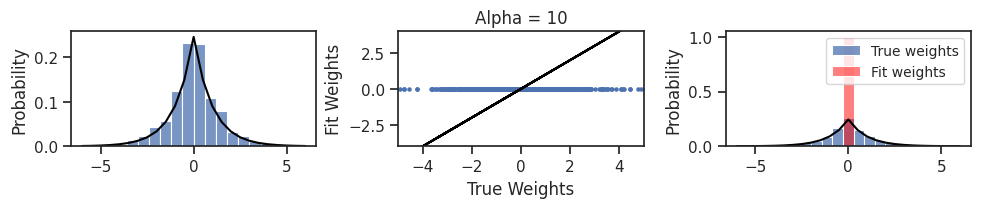

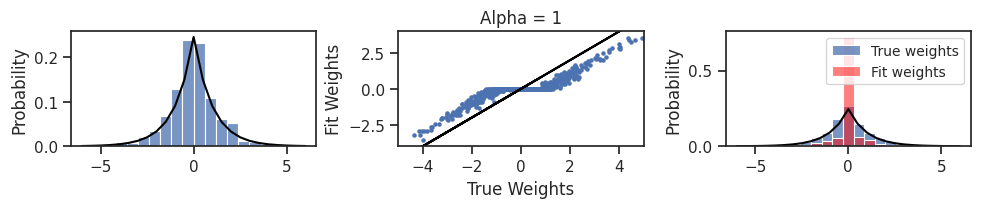

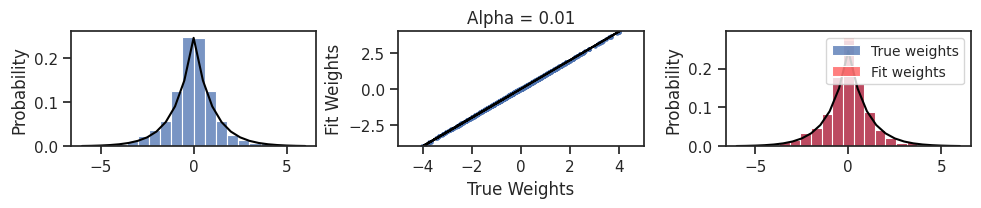

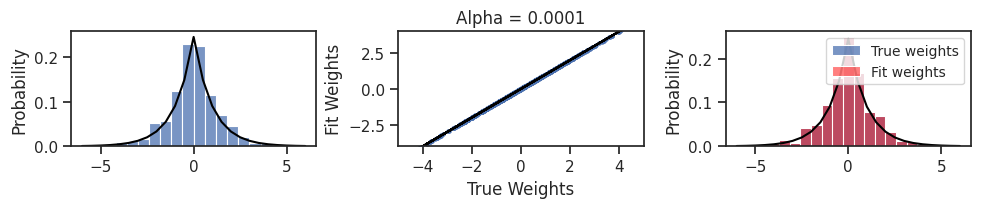

In [ ]:
#@title Let's see them all together (alpha=[10, 1, 0.01, 0.0001])
for ii,this_alpha in enumerate([10,1,.01,.0001]): #
      n = 10000         # define number of data points
      p = 1000          # define number of regressors
      x = np.random.randn(n,p) # Generate regressors

      # Sample true regression weights from exponential prior
      true_weights = np.random.laplace(loc=0.0, scale=1, size=(1000))#np.multiply(np.random.exponential(1,p),np.sign(np.random.rand(p)-0.5))

      # Generate data: y = w*x + noise
      noise = 0.1*np.random.randn(n)
      y = x @ true_weights + noise

      w_grid = np.linspace(start=-6,stop=6,num=25)
      p_grid = np.exp(-np.abs(w_grid))

      # Perform lasso
      ll = Lasso(alpha=this_alpha,fit_intercept=False)
      ll.fit(x,y)

      # Generate figure
      sns.set_theme(style="ticks")
      fig, axes = plt.subplots(1,3, figsize=(10,1.85), sharey='none', dpi=100)
      fig.tight_layout()

      # First axis
      sns.histplot(true_weights, binrange=[-6,6],ax=axes[0],bins=20,stat='probability')
      axes[0].plot(w_grid,p_grid/sum(p_grid),color='black')

      # Second axis
      axes[1].scatter(true_weights,ll.coef_,s=5)
      axes[1].plot(true_weights,true_weights,color='black')
      axes[1].set_xlim([-5,5])
      axes[1].set_ylim([-4,4])
      axes[1].set_xlabel("True Weights")
      axes[1].set_ylabel("Fit Weights")
      axes[1].set_title("Alpha = " + str(this_alpha))

      # Third axis
      sns.histplot(true_weights, binrange=[-6,6],ax=axes[2],bins=21,stat='probability',label='True weights')
      sns.histplot(ll.coef_, binrange=[-6,6],ax=axes[2],bins=21,stat='probability',color='red',alpha=.5,label='Fit weights')
      axes[2].plot(w_grid,p_grid/sum(p_grid),color='black')
      axes[2].legend(fontsize=10)

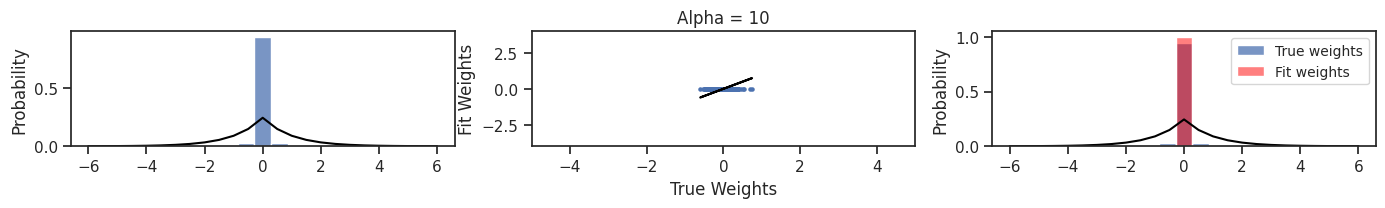

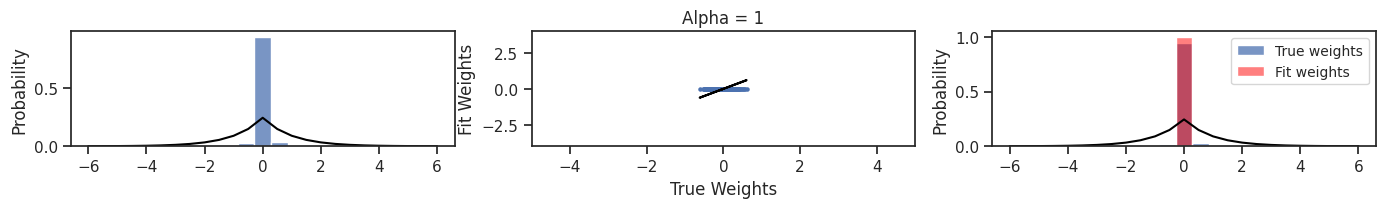

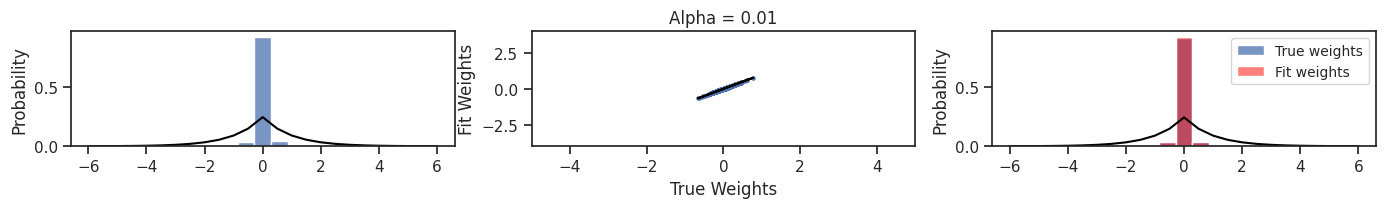

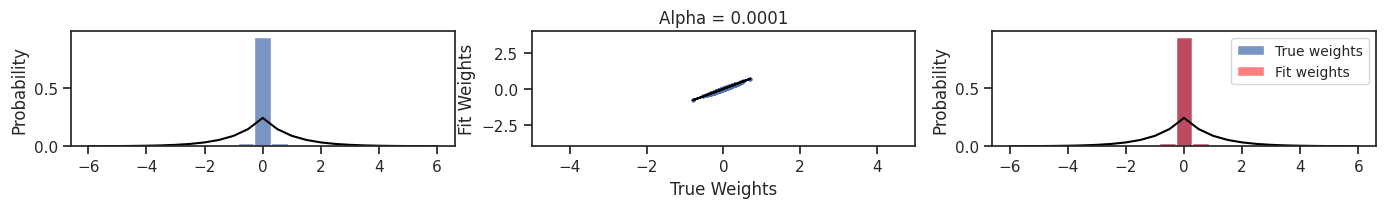

In [ ]:
#@title Let's try it one more time but now we will define the standard deviation of the distribution to be much much smaller, i.e. a 'peakier', more sparse, distribution for the prior
for ii,this_alpha in enumerate([10,1,.01,.0001]): #
      n = 10000         # define number of data points
      p = 1000          # define number of regressors
      x = np.random.randn(n,p) # Generate regressors

      # Sample true regression weights from exponential prior
      true_weights = np.random.laplace(loc=0.0, scale=0.1, size=(1000))#np.multiply(np.random.exponential(1,p),np.sign(np.random.rand(p)-0.5))

      # Generate data: y = w*x + noise
      noise = 0.1*np.random.randn(n)
      y = x @ true_weights + noise

      w_grid = np.linspace(start=-6,stop=6,num=25)
      p_grid = np.exp(-np.abs(w_grid))

      # Perform lasso
      ll = Lasso(alpha=this_alpha,fit_intercept=False)
      ll.fit(x,y)

      # Generate figure
      sns.set_theme(style="ticks")
      fig, axes = plt.subplots(1,3, figsize=(14,1.85), sharey='none', dpi=100)
      fig.tight_layout()

      # First axis
      sns.histplot(true_weights, binrange=[-6,6],ax=axes[0],bins=21,stat='probability')
      axes[0].plot(w_grid,p_grid/sum(p_grid),color='black')

      # Second axis
      axes[1].scatter(true_weights,ll.coef_,s=5)
      axes[1].plot(true_weights,true_weights,color='black')
      axes[1].set_xlim([-5,5])
      axes[1].set_ylim([-4,4])
      axes[1].set_xlabel("True Weights")
      axes[1].set_ylabel("Fit Weights")
      axes[1].set_title("Alpha = " + str(this_alpha))

      # Third axis
      sns.histplot(true_weights, binrange=[-6,6],ax=axes[2],bins=21,stat='probability',label='True weights')
      sns.histplot(ll.coef_, binrange=[-6,6],ax=axes[2],bins=21,stat='probability',color='red',alpha=.5,label='Fit weights')
      axes[2].plot(w_grid,p_grid/sum(p_grid),color='black')
      axes[2].legend(fontsize=10)

In [ ]:
%%shell
jupyter nbconvert Norms_And_Sparsity_V2.ipynb --to markdown --output norms_and_sparsity.md

[NbConvertApp] Converting notebook Norms_And_Sparsity_V2.ipynb to markdown
[NbConvertApp] Support files will be in norms_and_sparsity_files/
[NbConvertApp] Making directory norms_and_sparsity_files
[NbConvertApp] Making directory norms_and_sparsity_files
[NbConvertApp] Making directory norms_and_sparsity_files
[NbConvertApp] Making directory norms_and_sparsity_files
[NbConvertApp] Making directory norms_and_sparsity_files
[NbConvertApp] Making directory norms_and_sparsity_files
[NbConvertApp] Making directory norms_and_sparsity_files
[NbConvertApp] Making directory norms_and_sparsity_files
[NbConvertApp] Making directory norms_and_sparsity_files
[NbConvertApp] Making directory norms_and_sparsity_files
[NbConvertApp] Making directory norms_and_sparsity_files
[NbConvertApp] Making directory norms_and_sparsity_files
[NbConvertApp] Making directory norms_and_sparsity_files
[NbConvertApp] Making directory norms_and_sparsity_files
[NbConvertApp] Making directory norms_and_sparsity_files
[NbC

In [ ]:
!zip -r /content/norms_and_sparsity.zip /content/norms_and_sparsity.md
from google.colab import files
files.download("/content/norms_and_sparsity.zip")

  adding: content/norms_and_sparsity.md (deflated 81%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

updating: content/norms_and_sparsity_files/ (stored 0%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_19_0.png (deflated 5%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_8_1.png (deflated 7%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_7_1.png (deflated 4%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_18_2.png (deflated 5%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_23_2.png (deflated 6%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_18_3.png (deflated 5%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_6_0.png (deflated 6%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_18_4.png (deflated 5%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_21_0.png (deflated 6%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_18_0.png (deflated 5%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_12_2.png (deflated 3%)
updating: co

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r /content/norms_and_sparsity_files.zip /content/norms_and_sparsity_files
files.download("/content/norms_and_sparsity_files.zip")

updating: content/norms_and_sparsity_files/ (stored 0%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_19_0.png (deflated 5%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_8_1.png (deflated 7%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_7_1.png (deflated 4%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_18_2.png (deflated 5%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_23_2.png (deflated 6%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_18_3.png (deflated 5%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_6_0.png (deflated 6%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_18_4.png (deflated 5%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_21_0.png (deflated 6%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_18_0.png (deflated 5%)
updating: content/norms_and_sparsity_files/norms_and_sparsity_12_2.png (deflated 3%)
updating: co

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>